In [1]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict
from IPython.display import clear_output
import math
from sklearn.model_selection import GridSearchCV
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [3]:
year = 2003
month = 2
day = 10
hour = 0
minute = 0
second = 0

startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day, hour+23, minute+59, second+59]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day, hour+23, minute+59, second+59)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=[]

for x in allMatData:
    allStationCodes.append(x[1][0])
    

In [4]:
%%time
for st in allStationCodes: 
    try:
        stationsOut[st] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(st))
    except:
        stationsNonexistentInFolder.append(st)

CPU times: user 331 ms, sys: 71.4 ms, total: 402 ms
Wall time: 2.56 s


In [5]:
def IndicatorCalculation(dataSt, timeshift, currentDate):
    
#     a1=np.float32(dataSt.get("a1")[timeshift])
#     x=np.float32(dataSt.get("x")[timeshift])
    x1=np.float32(dataSt.get("x1")[timeshift])
    x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
    y=np.float32(dataSt.get("y")[timeshift])
    y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
    z1=np.float32(dataSt.get("z1")[timeshift])
    stLongeo=np.float32(dataSt.get("longeo"))
    stLatgeo=np.float32(dataSt.get("latgeo"))
    stAlt=np.float32(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    
    ratio = (((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/b[3])-1)*100
#     indicator = gaussian(ratio, 1, 0)
    return np.round(x2,10)

In [6]:
%%time
stationIndicatorVariation.clear()
timeBetweenValues = 1
dataResolution = 0
dataBeforeNormalizaton = np.array([])
st = "clf"
delta = endDate-startDate
totalMinutes = (delta.total_seconds()+1)/60
for i in range(0, np.int16(totalMinutes+1), timeBetweenValues):
    try:
        update = datetime.timedelta(minutes=i)
        currentDate = startDate+update
        stationIndicatorVariation[st].append(float(IndicatorCalculation(stationsOut.get(st), i, currentDate)))
    except:
        None

CPU times: user 1.88 s, sys: 56.3 ms, total: 1.94 s
Wall time: 3.3 s


In [7]:
normalized01StationIndicatorVariation = defaultdict(list)

def NormalizeData01():
    max_values = np.array([])
    min_values = np.array([])
    
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            if not math.isnan(stationIndicatorVariation[st][0]):
                max_values = np.append(max_values, max(stationIndicatorVariation[st])) 
                min_values = np.append(min_values, min(stationIndicatorVariation[st]))
    
    totalMax = max(max_values)
    totalMin = min(min_values)
    
    for st in allStationCodes:
        for i in range(0, len(stationIndicatorVariation[st])):
            normalized01StationIndicatorVariation[st].append((stationIndicatorVariation[st][i] - totalMin) / (totalMax - totalMin))
            
NormalizeData01()

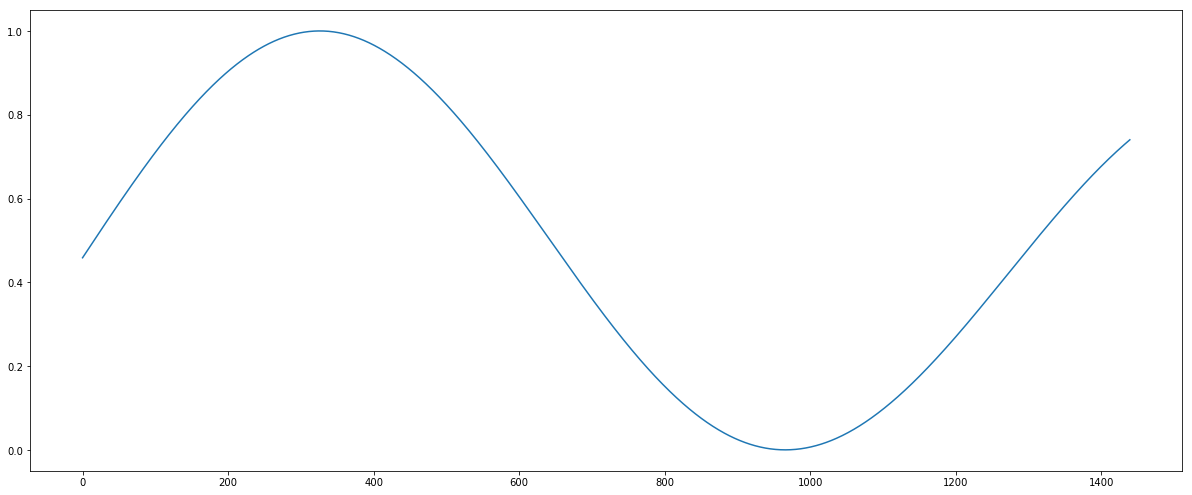

In [8]:
y = np.array(normalized01StationIndicatorVariation["clf"])
x = np.arange(0, 1440, timeBetweenValues)
fig= plt.figure(figsize=(20,8))
axes= fig.add_axes([0.8,0.8,0.8,0.8])
axes.plot(x,y)
plt.show()

In [9]:
def SupportVectorRegression(latValues, indicatorValues,params):
    svr_rbf = SVR(kernel='rbf', C=params['C'], gamma=params['gamma'])
    SVRmodel = svr_rbf.fit(latValues, indicatorValues)
    
    return SVRmodel


def RemoveInfNan(latValues, indicatorValues):
    indexDeleteY = np.array([])
    for i in range(0, indicatorValues.shape[0]):
        if math.isinf(indicatorValues[i]) or math.isnan(indicatorValues[i]):
            indexDeleteY = np.append(indexDeleteY, i)
    newY = np.delete(indicatorValues, indexDeleteY)
    newX = np.delete(latValues, indexDeleteY)
    newY=newY.reshape(newY.shape[0],1)
    newX=newX.reshape(newY.shape[0],1)
    
    return newX, newY

In [10]:
def ParametersTuning(): 
    parameters = {'kernel':['rbf'], 'gamma': [0.01, 0.1, 0.5, 0.9],'C': [50, 100, 1000, 1e4, 1e5]}
    svr = GridSearchCV(SVR(), parameters)
    svr.fit(X_train, y_train)
    print('score',svr.score(X_test.reshape(X_test.shape[0],1), y_test.reshape(y_test.shape[0],1)))
    modelBestParams = svr.best_params_
    print ("Parameters tuning finished, best params: {}".format(modelBestParams))
    return modelBestParams

In [18]:
predictionGap = np.array([])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, shuffle=True)



def RemoveDataRandomly(x,y):
    rand = np.array([])
    r=0
    for i in range(0,y.shape[0]/2):
        while r in rand:
            r = random.randint(0,y.shape[0])
        rand = np.append(rand, r)

    for i in range(0,rand.shape[0]):
        y_train[np.int16(rand[i])] = np.nan
        
        
def RemoveDataGap(start, end):
    global predictionGap
    
    for i in range(start, end, 1):
        for y in range(0, X_train.shape[0]):
            if i == X_train[y]:
                y_train[y] = np.nan
                predictionGap = np.append(predictionGap,X_train[y])
        
# RemoveDataRandomly()
RemoveDataGap(200,500)

In [19]:
X_train = X_train.reshape(X_train.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1) 
X_test = X_test.reshape(X_test.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

X_train, y_train = RemoveInfNan(X_train, y_train)

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
parameters = {'kernel':['rbf', 'poly'], 'gamma': [0.01, 0.1, 0.5, 0.9],'C': [50, 100, 1000, 1e4, 1e5], 'degree': [2, 3]}
svr = GridSearchCV(SVR(), parameters)
model=svr.fit(X_train, y_train)
print('score',svr.score(X_test.reshape(X_test.shape[0],1), y_test.reshape(y_test.shape[0],1)))

modelBestParams = svr.best_params_
print ("Parameters tuning finished, best params: {}".format(modelBestParams))


y_true = np.array([])
y_pred = model.predict(predictionGap.reshape(predictionGap.shape[0], 1))
for i in range(0,predictionGap.shape[0]):
    y_true = np.append(y_true, y[np.int16(predictionGap[i])])

print("MSE - {}".format(mean_absolute_error(y_true, y_pred)))
xPrediction = np.arange(0,1440,1)
ShowTrainTestSplit(predictionGap, y_pred, xPrediction.reshape(xPrediction.shape[0],1), model.predict(xPrediction.reshape(xPrediction.shape[0],1)))

In [15]:
def ShowTrainTestSplit(xAxis,yAxis, xPrediction, yPrediction):
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.scatter(X_train, y_train)
#     ax1.scatter(xAxis,yAxis, color='red')
    ax1.plot(xPrediction, yPrediction, 'r:')
    ax2.scatter(X_test, y_test)
    ax1.title.set_text('Train')
    ax2.title.set_text('Test')
    ax3.scatter(x,y)
    ax3.title.set_text('Full set')
    fig.set_size_inches(15,5)

In [ ]:
# afterPrediction = np.full((y.shape[0],1), np.nan)
# afterPrediction[:] = y

# for i in range(0,y.shape[0]):
#     if math.isnan(afterPrediction[i]): 
#         afterPrediction[i] = SVRmodel.predict(i)
# x = np.arange(0,y.shape[0],1)      
# plt.scatter(x,afterPrediction)
# plt.savefig('plot.png')

In [95]:
# np.savetxt("afterPrediction2003.csv", afterPrediction, delimiter=",")